回帰
241

optunaでハイパラチューニング

## 必要なライブラリのimport

In [4]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_40.csv'
train = pd.read_csv(path_train_prepro)

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [3]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',]
# 'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
# 'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
# 'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [ ]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [10]:
# 目的関数
def objective(trial):
    # ハイパーパラメータの範囲を指定
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 1.0),
        "bagging_seed": 11,
        "random_state": 133,
        "verbosity": -1
    }

    # KFold交差検証
    folds = KFold(n_splits=3, shuffle=True, random_state=26)
    rmse_list = []

    #for train_index, val_index in kf.split(X):
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))

        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                            label=target.iloc[trn_idx],
                            categorical_feature=categorical_feats
                            )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                            label=target.iloc[val_idx],
                            categorical_feature=categorical_feats
                            )

        num_round = 1000
        model = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=100),
                                lgb.log_evaluation(100)],
                    )


        #model = lgb.train(param, trn_data, valid_sets=[val_data], early_stopping_rounds=100, verbose_eval=False)
        #y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = model.predict(train.iloc[val_idx][features], num_iteration=model.best_iteration)
        rmse = mean_squared_error(target.iloc[val_idx], y_pred, squared=False)
        #rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Optunaによるハイパーパラメータチューニング
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best trial:')
trial = study.best_trial
print('  RMSE: {}'.format(trial.value))
print('  Best hyperparameters: {}'.format(trial.params))

[I 2024-06-24 16:20:17,143] A new study created in memory with name: no-name-6fced570-6472-462d-8858-3f4de15e7bb9


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.72583
[200]	valid_0's rmse: 3.69688
[300]	valid_0's rmse: 3.68244
[400]	valid_0's rmse: 3.67459
[500]	valid_0's rmse: 3.66932
[600]	valid_0's rmse: 3.66519
[700]	valid_0's rmse: 3.6617
[800]	valid_0's rmse: 3.65969
[900]	valid_0's rmse: 3.65689
[1000]	valid_0's rmse: 3.65528
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 3.65523
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.77082
[200]	valid_0's rmse: 3.7392
[300]	valid_0's rmse: 3.72506
[400]	valid_0's rmse: 3.71799
[500]	valid_0's rmse: 3.71233
[600]	valid_0's rmse: 3.70828
[700]	valid_0's rmse: 3.70552
[800]	valid_0's rmse: 3.70252
[900]	valid_0's rmse: 3.70064
[1000]	valid_0's rmse: 3.69857
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 3.69853
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.75212
[

[I 2024-06-24 16:20:57,085] Trial 0 finished with value: 3.6797992125946 and parameters: {'learning_rate': 0.010266668598609316, 'num_leaves': 110, 'max_depth': 3, 'min_data_in_leaf': 76, 'feature_fraction': 0.6633397306652614, 'bagging_fraction': 0.7004380706229956, 'bagging_freq': 5, 'lambda_l1': 0.9356739976252267, 'lambda_l2': 0.5442212671345776}. Best is trial 0 with value: 3.6797992125946.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.64054
[200]	valid_0's rmse: 3.63946
Early stopping, best iteration is:
[158]	valid_0's rmse: 3.63748
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.6837
[200]	valid_0's rmse: 3.6859
Early stopping, best iteration is:
[112]	valid_0's rmse: 3.68265
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.67078
[200]	valid_0's rmse: 3.67487
Early stopping, best iteration is:
[118]	valid_0's rmse: 3.67009


[I 2024-06-24 16:21:16,313] Trial 1 finished with value: 3.663407537005407 and parameters: {'learning_rate': 0.08514248258334144, 'num_leaves': 100, 'max_depth': 5, 'min_data_in_leaf': 83, 'feature_fraction': 0.6758777131791622, 'bagging_fraction': 0.717304572916084, 'bagging_freq': 1, 'lambda_l1': 0.22810218504618596, 'lambda_l2': 0.22427396928196003}. Best is trial 1 with value: 3.663407537005407.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.75609
[200]	valid_0's rmse: 3.71671
[300]	valid_0's rmse: 3.69333
[400]	valid_0's rmse: 3.67804
[500]	valid_0's rmse: 3.66808
[600]	valid_0's rmse: 3.6606
[700]	valid_0's rmse: 3.65523
[800]	valid_0's rmse: 3.65113
[900]	valid_0's rmse: 3.64797
[1000]	valid_0's rmse: 3.64561
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.64561
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.80243
[200]	valid_0's rmse: 3.76168
[300]	valid_0's rmse: 3.73755
[400]	valid_0's rmse: 3.72222
[500]	valid_0's rmse: 3.7118
[600]	valid_0's rmse: 3.70499
[700]	valid_0's rmse: 3.69963
[800]	valid_0's rmse: 3.69571
[900]	valid_0's rmse: 3.69286
[1000]	valid_0's rmse: 3.69037
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.69037
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.78501

[I 2024-06-24 16:22:27,146] Trial 2 finished with value: 3.67175880212417 and parameters: {'learning_rate': 0.003424658983812829, 'num_leaves': 184, 'max_depth': 5, 'min_data_in_leaf': 61, 'feature_fraction': 0.895757296644494, 'bagging_fraction': 0.7107055585693183, 'bagging_freq': 1, 'lambda_l1': 0.3981255966696924, 'lambda_l2': 0.3566470016675328}. Best is trial 1 with value: 3.663407537005407.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.63768
[200]	valid_0's rmse: 3.63749
Early stopping, best iteration is:
[110]	valid_0's rmse: 3.63708
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.68561
Early stopping, best iteration is:
[96]	valid_0's rmse: 3.68519
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.67832
Early stopping, best iteration is:
[81]	valid_0's rmse: 3.6776


[I 2024-06-24 16:23:01,346] Trial 3 finished with value: 3.66662219059997 and parameters: {'learning_rate': 0.042049641898012385, 'num_leaves': 180, 'max_depth': 9, 'min_data_in_leaf': 50, 'feature_fraction': 0.7247931611888584, 'bagging_fraction': 0.9290081973033206, 'bagging_freq': 1, 'lambda_l1': 0.2681935382294845, 'lambda_l2': 0.3070015809792984}. Best is trial 1 with value: 3.663407537005407.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.68921
[200]	valid_0's rmse: 3.6706
[300]	valid_0's rmse: 3.66226
[400]	valid_0's rmse: 3.65728
[500]	valid_0's rmse: 3.65375
[600]	valid_0's rmse: 3.65101
[700]	valid_0's rmse: 3.64938
[800]	valid_0's rmse: 3.64791
[900]	valid_0's rmse: 3.64785
[1000]	valid_0's rmse: 3.64688
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 3.64683
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.73419
[200]	valid_0's rmse: 3.71452
[300]	valid_0's rmse: 3.70633
[400]	valid_0's rmse: 3.70087
[500]	valid_0's rmse: 3.69808
[600]	valid_0's rmse: 3.69585
[700]	valid_0's rmse: 3.69422
[800]	valid_0's rmse: 3.69252
[900]	valid_0's rmse: 3.69188
[1000]	valid_0's rmse: 3.69187
Did not meet early stopping. Best iteration is:
[976]	valid_0's rmse: 3.6916
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.71794
[

[I 2024-06-24 16:23:51,268] Trial 4 finished with value: 3.671695944596712 and parameters: {'learning_rate': 0.024467786979741134, 'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 96, 'feature_fraction': 0.6879299104804142, 'bagging_fraction': 0.9219228548945121, 'bagging_freq': 4, 'lambda_l1': 0.3498606726119081, 'lambda_l2': 0.4219511862517862}. Best is trial 1 with value: 3.663407537005407.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.76892
[200]	valid_0's rmse: 3.73161
[300]	valid_0's rmse: 3.70568
[400]	valid_0's rmse: 3.6877
[500]	valid_0's rmse: 3.67496
[600]	valid_0's rmse: 3.66557
[700]	valid_0's rmse: 3.65918
[800]	valid_0's rmse: 3.65416
[900]	valid_0's rmse: 3.6504
[1000]	valid_0's rmse: 3.64755
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.64755
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.81761
[200]	valid_0's rmse: 3.77921
[300]	valid_0's rmse: 3.75305
[400]	valid_0's rmse: 3.73501
[500]	valid_0's rmse: 3.72219
[600]	valid_0's rmse: 3.71273
[700]	valid_0's rmse: 3.7059
[800]	valid_0's rmse: 3.70097
[900]	valid_0's rmse: 3.69724
[1000]	valid_0's rmse: 3.69438
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.69438
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7991
[

[I 2024-06-24 16:29:28,266] Trial 5 finished with value: 3.6731635358776704 and parameters: {'learning_rate': 0.0020658773469456075, 'num_leaves': 180, 'max_depth': 9, 'min_data_in_leaf': 123, 'feature_fraction': 0.8214570840304359, 'bagging_fraction': 0.9881764852238965, 'bagging_freq': 5, 'lambda_l1': 0.49039489667597397, 'lambda_l2': 0.17856527285537593}. Best is trial 1 with value: 3.663407537005407.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.6708
[200]	valid_0's rmse: 3.64465
[300]	valid_0's rmse: 3.63764
[400]	valid_0's rmse: 3.63458
[500]	valid_0's rmse: 3.63407
[600]	valid_0's rmse: 3.63308
Early stopping, best iteration is:
[592]	valid_0's rmse: 3.63298
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.71673
[200]	valid_0's rmse: 3.68945
[300]	valid_0's rmse: 3.68317
[400]	valid_0's rmse: 3.68045
[500]	valid_0's rmse: 3.6805
Early stopping, best iteration is:
[464]	valid_0's rmse: 3.68017
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.69982
[200]	valid_0's rmse: 3.67351
[300]	valid_0's rmse: 3.669
[400]	valid_0's rmse: 3.6674
[500]	valid_0's rmse: 3.6669
[600]	valid_0's rmse: 3.66689
Early stopping, best iteration is:
[522]	valid_0's rmse: 3.66665


[I 2024-06-24 16:32:48,171] Trial 6 finished with value: 3.659934571091133 and parameters: {'learning_rate': 0.01125485545291901, 'num_leaves': 195, 'max_depth': 9, 'min_data_in_leaf': 168, 'feature_fraction': 0.7270112284770077, 'bagging_fraction': 0.7397773432635686, 'bagging_freq': 6, 'lambda_l1': 0.2792227857582406, 'lambda_l2': 0.11076664852790992}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.69749
[200]	valid_0's rmse: 3.66546
[300]	valid_0's rmse: 3.65173
[400]	valid_0's rmse: 3.64525
[500]	valid_0's rmse: 3.64172
[600]	valid_0's rmse: 3.63917
[700]	valid_0's rmse: 3.63717
[800]	valid_0's rmse: 3.6361
[900]	valid_0's rmse: 3.63545
[1000]	valid_0's rmse: 3.63439
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 3.63438
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.74286
[200]	valid_0's rmse: 3.70991
[300]	valid_0's rmse: 3.69791
[400]	valid_0's rmse: 3.69186
[500]	valid_0's rmse: 3.68897
[600]	valid_0's rmse: 3.68684
[700]	valid_0's rmse: 3.68552
[800]	valid_0's rmse: 3.68414
[900]	valid_0's rmse: 3.68338
[1000]	valid_0's rmse: 3.68341
Early stopping, best iteration is:
[900]	valid_0's rmse: 3.68338
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.72799
[200]	valid_0

[I 2024-06-24 16:34:59,714] Trial 7 finished with value: 3.6627180940523267 and parameters: {'learning_rate': 0.009619753314475257, 'num_leaves': 106, 'max_depth': 5, 'min_data_in_leaf': 112, 'feature_fraction': 0.9437890599434524, 'bagging_fraction': 0.9811605359368829, 'bagging_freq': 4, 'lambda_l1': 0.8444168217473045, 'lambda_l2': 0.9053707000292086}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.65859
[200]	valid_0's rmse: 3.64043
[300]	valid_0's rmse: 3.63506
[400]	valid_0's rmse: 3.63503
Early stopping, best iteration is:
[354]	valid_0's rmse: 3.63461
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7035
[200]	valid_0's rmse: 3.68492
[300]	valid_0's rmse: 3.68067
[400]	valid_0's rmse: 3.68083
Early stopping, best iteration is:
[339]	valid_0's rmse: 3.67995
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.68875
[200]	valid_0's rmse: 3.67181
[300]	valid_0's rmse: 3.67047
[400]	valid_0's rmse: 3.66985
Early stopping, best iteration is:
[328]	valid_0's rmse: 3.6696


[I 2024-06-24 16:36:06,214] Trial 8 finished with value: 3.6613856619395047 and parameters: {'learning_rate': 0.01583413681836484, 'num_leaves': 92, 'max_depth': 9, 'min_data_in_leaf': 68, 'feature_fraction': 0.6433036837721864, 'bagging_fraction': 0.9238856051739749, 'bagging_freq': 5, 'lambda_l1': 0.5994131191053048, 'lambda_l2': 0.26151096511975985}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.67556
[200]	valid_0's rmse: 3.65485
[300]	valid_0's rmse: 3.64695
[400]	valid_0's rmse: 3.64249
[500]	valid_0's rmse: 3.64008
[600]	valid_0's rmse: 3.63785
[700]	valid_0's rmse: 3.63613
[800]	valid_0's rmse: 3.63549
[900]	valid_0's rmse: 3.63454
[1000]	valid_0's rmse: 3.63483
Early stopping, best iteration is:
[900]	valid_0's rmse: 3.63454
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.719
[200]	valid_0's rmse: 3.69828
[300]	valid_0's rmse: 3.69189
[400]	valid_0's rmse: 3.68835
[500]	valid_0's rmse: 3.68635
[600]	valid_0's rmse: 3.68562
[700]	valid_0's rmse: 3.68456
[800]	valid_0's rmse: 3.68432
Early stopping, best iteration is:
[740]	valid_0's rmse: 3.68392
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.70488
[200]	valid_0's rmse: 3.68573
[300]	valid_0's rmse: 3.67915
[400]	valid_0's rmse: 3.6758

[I 2024-06-24 16:37:00,401] Trial 9 finished with value: 3.662384589049411 and parameters: {'learning_rate': 0.020819996601653328, 'num_leaves': 130, 'max_depth': 4, 'min_data_in_leaf': 135, 'feature_fraction': 0.6362564238204621, 'bagging_fraction': 0.8732944530220592, 'bagging_freq': 5, 'lambda_l1': 0.12124690826147548, 'lambda_l2': 0.3235257623594072}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.79618
[200]	valid_0's rmse: 3.77324
[300]	valid_0's rmse: 3.7544
[400]	valid_0's rmse: 3.73781
[500]	valid_0's rmse: 3.72409
[600]	valid_0's rmse: 3.71269
[700]	valid_0's rmse: 3.70252
[800]	valid_0's rmse: 3.69415
[900]	valid_0's rmse: 3.68735
[1000]	valid_0's rmse: 3.68138
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.68138
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.84604
[200]	valid_0's rmse: 3.82206
[300]	valid_0's rmse: 3.80211
[400]	valid_0's rmse: 3.78538
[500]	valid_0's rmse: 3.77129
[600]	valid_0's rmse: 3.7595
[700]	valid_0's rmse: 3.74927
[800]	valid_0's rmse: 3.74048
[900]	valid_0's rmse: 3.7332
[1000]	valid_0's rmse: 3.72699
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.72699
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.82539


[I 2024-06-24 16:38:33,304] Trial 10 finished with value: 3.706176660706736 and parameters: {'learning_rate': 0.0010540856448048477, 'num_leaves': 152, 'max_depth': 7, 'min_data_in_leaf': 199, 'feature_fraction': 0.7828112512707789, 'bagging_fraction': 0.6080711953714161, 'bagging_freq': 7, 'lambda_l1': 0.15111425976869444, 'lambda_l2': 0.10061240130216911}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.69746
[200]	valid_0's rmse: 3.65905
[300]	valid_0's rmse: 3.64529
[400]	valid_0's rmse: 3.63812
[500]	valid_0's rmse: 3.6347
[600]	valid_0's rmse: 3.63344
[700]	valid_0's rmse: 3.63211
[800]	valid_0's rmse: 3.63142
[900]	valid_0's rmse: 3.63104
[1000]	valid_0's rmse: 3.63128
Did not meet early stopping. Best iteration is:
[915]	valid_0's rmse: 3.63097
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7456
[200]	valid_0's rmse: 3.70699
[300]	valid_0's rmse: 3.69328
[400]	valid_0's rmse: 3.68782
[500]	valid_0's rmse: 3.68515
[600]	valid_0's rmse: 3.68362
[700]	valid_0's rmse: 3.68331
[800]	valid_0's rmse: 3.68327
Early stopping, best iteration is:
[766]	valid_0's rmse: 3.683
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.72727
[200]	valid_0's rmse: 3.69053
[300]	valid_0's rmse: 3.67793
[400]	valid_0's r

[I 2024-06-24 16:39:56,505] Trial 11 finished with value: 3.660417943145339 and parameters: {'learning_rate': 0.007860073837339986, 'num_leaves': 66, 'max_depth': 10, 'min_data_in_leaf': 165, 'feature_fraction': 0.6106282629594216, 'bagging_fraction': 0.8167997273097803, 'bagging_freq': 7, 'lambda_l1': 0.5754240460649745, 'lambda_l2': 0.11546438298301887}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.72709
[200]	valid_0's rmse: 3.68326
[300]	valid_0's rmse: 3.66271
[400]	valid_0's rmse: 3.65068
[500]	valid_0's rmse: 3.64399
[600]	valid_0's rmse: 3.6399
[700]	valid_0's rmse: 3.63641
[800]	valid_0's rmse: 3.63414
[900]	valid_0's rmse: 3.633
[1000]	valid_0's rmse: 3.63199
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 3.63197
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.77467
[200]	valid_0's rmse: 3.73039
[300]	valid_0's rmse: 3.70925
[400]	valid_0's rmse: 3.69789
[500]	valid_0's rmse: 3.69179
[600]	valid_0's rmse: 3.68798
[700]	valid_0's rmse: 3.68519
[800]	valid_0's rmse: 3.68322
[900]	valid_0's rmse: 3.68204
[1000]	valid_0's rmse: 3.68138
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 3.68133
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.75655
[2

[I 2024-06-24 16:41:41,281] Trial 12 finished with value: 3.660196902076091 and parameters: {'learning_rate': 0.005041877054159561, 'num_leaves': 59, 'max_depth': 10, 'min_data_in_leaf': 172, 'feature_fraction': 0.6052820708692821, 'bagging_fraction': 0.7995923888752483, 'bagging_freq': 7, 'lambda_l1': 0.19709859575869051, 'lambda_l2': 0.10487992039792285}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.744
[200]	valid_0's rmse: 3.70234
[300]	valid_0's rmse: 3.67992
[400]	valid_0's rmse: 3.66579
[500]	valid_0's rmse: 3.65678
[600]	valid_0's rmse: 3.65125
[700]	valid_0's rmse: 3.64631
[800]	valid_0's rmse: 3.64291
[900]	valid_0's rmse: 3.64085
[1000]	valid_0's rmse: 3.63882
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.63882
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.79049
[200]	valid_0's rmse: 3.7486
[300]	valid_0's rmse: 3.7251
[400]	valid_0's rmse: 3.7114
[500]	valid_0's rmse: 3.7025
[600]	valid_0's rmse: 3.69698
[700]	valid_0's rmse: 3.69272
[800]	valid_0's rmse: 3.69013
[900]	valid_0's rmse: 3.68826
[1000]	valid_0's rmse: 3.68667
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.68667
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.77254
[20

[I 2024-06-24 16:43:13,033] Trial 13 finished with value: 3.6661178370020675 and parameters: {'learning_rate': 0.0042176005784919654, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 167, 'feature_fraction': 0.7567043627224515, 'bagging_fraction': 0.766297553018275, 'bagging_freq': 7, 'lambda_l1': 0.1951740233642745, 'lambda_l2': 0.1564455960401095}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7326
[200]	valid_0's rmse: 3.69117
[300]	valid_0's rmse: 3.66955
[400]	valid_0's rmse: 3.65779
[500]	valid_0's rmse: 3.65154
[600]	valid_0's rmse: 3.64645
[700]	valid_0's rmse: 3.64342
[800]	valid_0's rmse: 3.64158
[900]	valid_0's rmse: 3.64026
[1000]	valid_0's rmse: 3.63941
Did not meet early stopping. Best iteration is:
[987]	valid_0's rmse: 3.63935
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.77866
[200]	valid_0's rmse: 3.73507
[300]	valid_0's rmse: 3.71411
[400]	valid_0's rmse: 3.70301
[500]	valid_0's rmse: 3.69575
[600]	valid_0's rmse: 3.69081
[700]	valid_0's rmse: 3.68759
[800]	valid_0's rmse: 3.68561
[900]	valid_0's rmse: 3.68411
[1000]	valid_0's rmse: 3.68325
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 3.68321
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.76205


[I 2024-06-24 16:44:58,912] Trial 14 finished with value: 3.6643271247862397 and parameters: {'learning_rate': 0.004815463708421006, 'num_leaves': 64, 'max_depth': 10, 'min_data_in_leaf': 22, 'feature_fraction': 0.8333257913451393, 'bagging_fraction': 0.8174605516892192, 'bagging_freq': 6, 'lambda_l1': 0.17481481923929362, 'lambda_l2': 0.1378156912637033}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.77059
[200]	valid_0's rmse: 3.73375
[300]	valid_0's rmse: 3.70808
[400]	valid_0's rmse: 3.68942
[500]	valid_0's rmse: 3.67616
[600]	valid_0's rmse: 3.6662
[700]	valid_0's rmse: 3.65869
[800]	valid_0's rmse: 3.65352
[900]	valid_0's rmse: 3.64902
[1000]	valid_0's rmse: 3.64601
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.64601
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.81915
[200]	valid_0's rmse: 3.7808
[300]	valid_0's rmse: 3.75422
[400]	valid_0's rmse: 3.73555
[500]	valid_0's rmse: 3.72214
[600]	valid_0's rmse: 3.71233
[700]	valid_0's rmse: 3.70509
[800]	valid_0's rmse: 3.69968
[900]	valid_0's rmse: 3.69555
[1000]	valid_0's rmse: 3.69197
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.69197
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.79892

[I 2024-06-24 16:46:43,038] Trial 15 finished with value: 3.671665676113221 and parameters: {'learning_rate': 0.0021728755824601737, 'num_leaves': 149, 'max_depth': 8, 'min_data_in_leaf': 194, 'feature_fraction': 0.718504050229212, 'bagging_fraction': 0.6372901232005518, 'bagging_freq': 6, 'lambda_l1': 0.2635805975871562, 'lambda_l2': 0.18140383254561238}. Best is trial 6 with value: 3.659934571091133.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.70994
[200]	valid_0's rmse: 3.66936
[300]	valid_0's rmse: 3.6517
[400]	valid_0's rmse: 3.64291
[500]	valid_0's rmse: 3.63785
[600]	valid_0's rmse: 3.63451
[700]	valid_0's rmse: 3.63294
[800]	valid_0's rmse: 3.6317
[900]	valid_0's rmse: 3.63071
[1000]	valid_0's rmse: 3.62972
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.62972
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.75613
[200]	valid_0's rmse: 3.71638
[300]	valid_0's rmse: 3.69896
[400]	valid_0's rmse: 3.69092
[500]	valid_0's rmse: 3.68619
[600]	valid_0's rmse: 3.68373
[700]	valid_0's rmse: 3.68235
[800]	valid_0's rmse: 3.68172
[900]	valid_0's rmse: 3.68128
[1000]	valid_0's rmse: 3.68046
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.68046
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.73866

[I 2024-06-24 16:48:45,440] Trial 16 finished with value: 3.658768506857694 and parameters: {'learning_rate': 0.006475461551266355, 'num_leaves': 61, 'max_depth': 8, 'min_data_in_leaf': 156, 'feature_fraction': 0.8846212117922798, 'bagging_fraction': 0.765677547837785, 'bagging_freq': 3, 'lambda_l1': 0.10564879395430914, 'lambda_l2': 0.13192387620183368}. Best is trial 16 with value: 3.658768506857694.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.63969
[200]	valid_0's rmse: 3.63752
[300]	valid_0's rmse: 3.6384
Early stopping, best iteration is:
[215]	valid_0's rmse: 3.63673
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.68841
[200]	valid_0's rmse: 3.68631
Early stopping, best iteration is:
[191]	valid_0's rmse: 3.68588
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.67224
[200]	valid_0's rmse: 3.67151
Early stopping, best iteration is:
[122]	valid_0's rmse: 3.67006


[I 2024-06-24 16:49:19,660] Trial 17 finished with value: 3.6642192890660197 and parameters: {'learning_rate': 0.036024530657378644, 'num_leaves': 76, 'max_depth': 8, 'min_data_in_leaf': 145, 'feature_fraction': 0.9973949327511448, 'bagging_fraction': 0.7508430750543271, 'bagging_freq': 3, 'lambda_l1': 0.10613600464255171, 'lambda_l2': 0.13259610383518286}. Best is trial 16 with value: 3.658768506857694.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.6982
[200]	valid_0's rmse: 3.6601
[300]	valid_0's rmse: 3.64547
[400]	valid_0's rmse: 3.63883
[500]	valid_0's rmse: 3.63558
[600]	valid_0's rmse: 3.63386
[700]	valid_0's rmse: 3.63306
[800]	valid_0's rmse: 3.633
[900]	valid_0's rmse: 3.63258
[1000]	valid_0's rmse: 3.63177
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 3.63172
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.74292
[200]	valid_0's rmse: 3.70441
[300]	valid_0's rmse: 3.69059
[400]	valid_0's rmse: 3.68542
[500]	valid_0's rmse: 3.68254
[600]	valid_0's rmse: 3.68067
[700]	valid_0's rmse: 3.67999
[800]	valid_0's rmse: 3.6799
[900]	valid_0's rmse: 3.67932
[1000]	valid_0's rmse: 3.67949
Did not meet early stopping. Best iteration is:
[927]	valid_0's rmse: 3.67905
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.72615
[200

[I 2024-06-24 16:50:54,926] Trial 18 finished with value: 3.6592028624004738 and parameters: {'learning_rate': 0.007469150025082949, 'num_leaves': 197, 'max_depth': 8, 'min_data_in_leaf': 149, 'feature_fraction': 0.8645450004252409, 'bagging_fraction': 0.6656536894887767, 'bagging_freq': 3, 'lambda_l1': 0.14044720315508621, 'lambda_l2': 0.2119893163983619}. Best is trial 16 with value: 3.658768506857694.


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.76414
[200]	valid_0's rmse: 3.72547
[300]	valid_0's rmse: 3.70033
[400]	valid_0's rmse: 3.6833
[500]	valid_0's rmse: 3.67149
[600]	valid_0's rmse: 3.66338
[700]	valid_0's rmse: 3.65667
[800]	valid_0's rmse: 3.65253
[900]	valid_0's rmse: 3.64888
[1000]	valid_0's rmse: 3.64615
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.64615
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.81193
[200]	valid_0's rmse: 3.77226
[300]	valid_0's rmse: 3.74673
[400]	valid_0's rmse: 3.72958
[500]	valid_0's rmse: 3.71789
[600]	valid_0's rmse: 3.70923
[700]	valid_0's rmse: 3.70299
[800]	valid_0's rmse: 3.69865
[900]	valid_0's rmse: 3.69524
[1000]	valid_0's rmse: 3.69281
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.69281
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.7929

[I 2024-06-24 16:52:45,313] Trial 19 finished with value: 3.67220867291165 and parameters: {'learning_rate': 0.0026510608170975426, 'num_leaves': 130, 'max_depth': 6, 'min_data_in_leaf': 144, 'feature_fraction': 0.8911244836473656, 'bagging_fraction': 0.6574943782463716, 'bagging_freq': 2, 'lambda_l1': 0.13729564758331367, 'lambda_l2': 0.21000247910189504}. Best is trial 16 with value: 3.658768506857694.


Best trial:
  RMSE: 3.658768506857694
  Best hyperparameters: {'learning_rate': 0.006475461551266355, 'num_leaves': 61, 'max_depth': 8, 'min_data_in_leaf': 156, 'feature_fraction': 0.8846212117922798, 'bagging_fraction': 0.765677547837785, 'bagging_freq': 3, 'lambda_l1': 0.10564879395430914, 'lambda_l2': 0.13192387620183368}


In [11]:
param = trial.params
param

{'learning_rate': 0.006475461551266355,
 'num_leaves': 61,
 'max_depth': 8,
 'min_data_in_leaf': 156,
 'feature_fraction': 0.8846212117922798,
 'bagging_fraction': 0.765677547837785,
 'bagging_freq': 3,
 'lambda_l1': 0.10564879395430914,
 'lambda_l2': 0.13192387620183368}

In [12]:
trial.value

3.658768506857694

In [13]:
param['objective'] = 'regression'
param['metric'] = 'rmse'
param['boosting_type'] = 'gbdt'
param['bagging_seed'] = 11
param['random_state'] = 133
param['verbosity'] = -1

In [14]:
param

{'learning_rate': 0.006475461551266355,
 'num_leaves': 61,
 'max_depth': 8,
 'min_data_in_leaf': 156,
 'feature_fraction': 0.8846212117922798,
 'bagging_fraction': 0.765677547837785,
 'bagging_freq': 3,
 'lambda_l1': 0.10564879395430914,
 'lambda_l2': 0.13192387620183368,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'bagging_seed': 11,
 'random_state': 133,
 'verbosity': -1}

In [15]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_44/', exist_ok=True)
    with open(f'../src/models/lgb_44/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.6962
[200]	valid_0's rmse: 3.65084
[300]	valid_0's rmse: 3.63171
[400]	valid_0's rmse: 3.62218
[500]	valid_0's rmse: 3.61748
[600]	valid_0's rmse: 3.61476
[700]	valid_0's rmse: 3.61282
[800]	valid_0's rmse: 3.61102
[900]	valid_0's rmse: 3.60993
[1000]	valid_0's rmse: 3.60892
[1100]	valid_0's rmse: 3.60774
[1200]	valid_0's rmse: 3.60797
[1300]	valid_0's rmse: 3.60784
[1400]	valid_0's rmse: 3.60769
[1500]	valid_0's rmse: 3.60779
[1600]	valid_0's rmse: 3.60774
[1700]	valid_0's rmse: 3.60757
[1800]	valid_0's rmse: 3.60743
[1900]	valid_0's rmse: 3.60805
Early stopping, best iteration is:
[1797]	valid_0's rmse: 3.60742
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.72806
[200]	valid_0's rmse: 3.68196
[300]	valid_0's rmse: 3.66197
[400]	valid_0's rmse: 3.65237
[500]	valid_0's rmse: 3.64722
[600]	valid_0's rmse: 3.64266
[700]	valid_0's rmse: 3.64038
[80

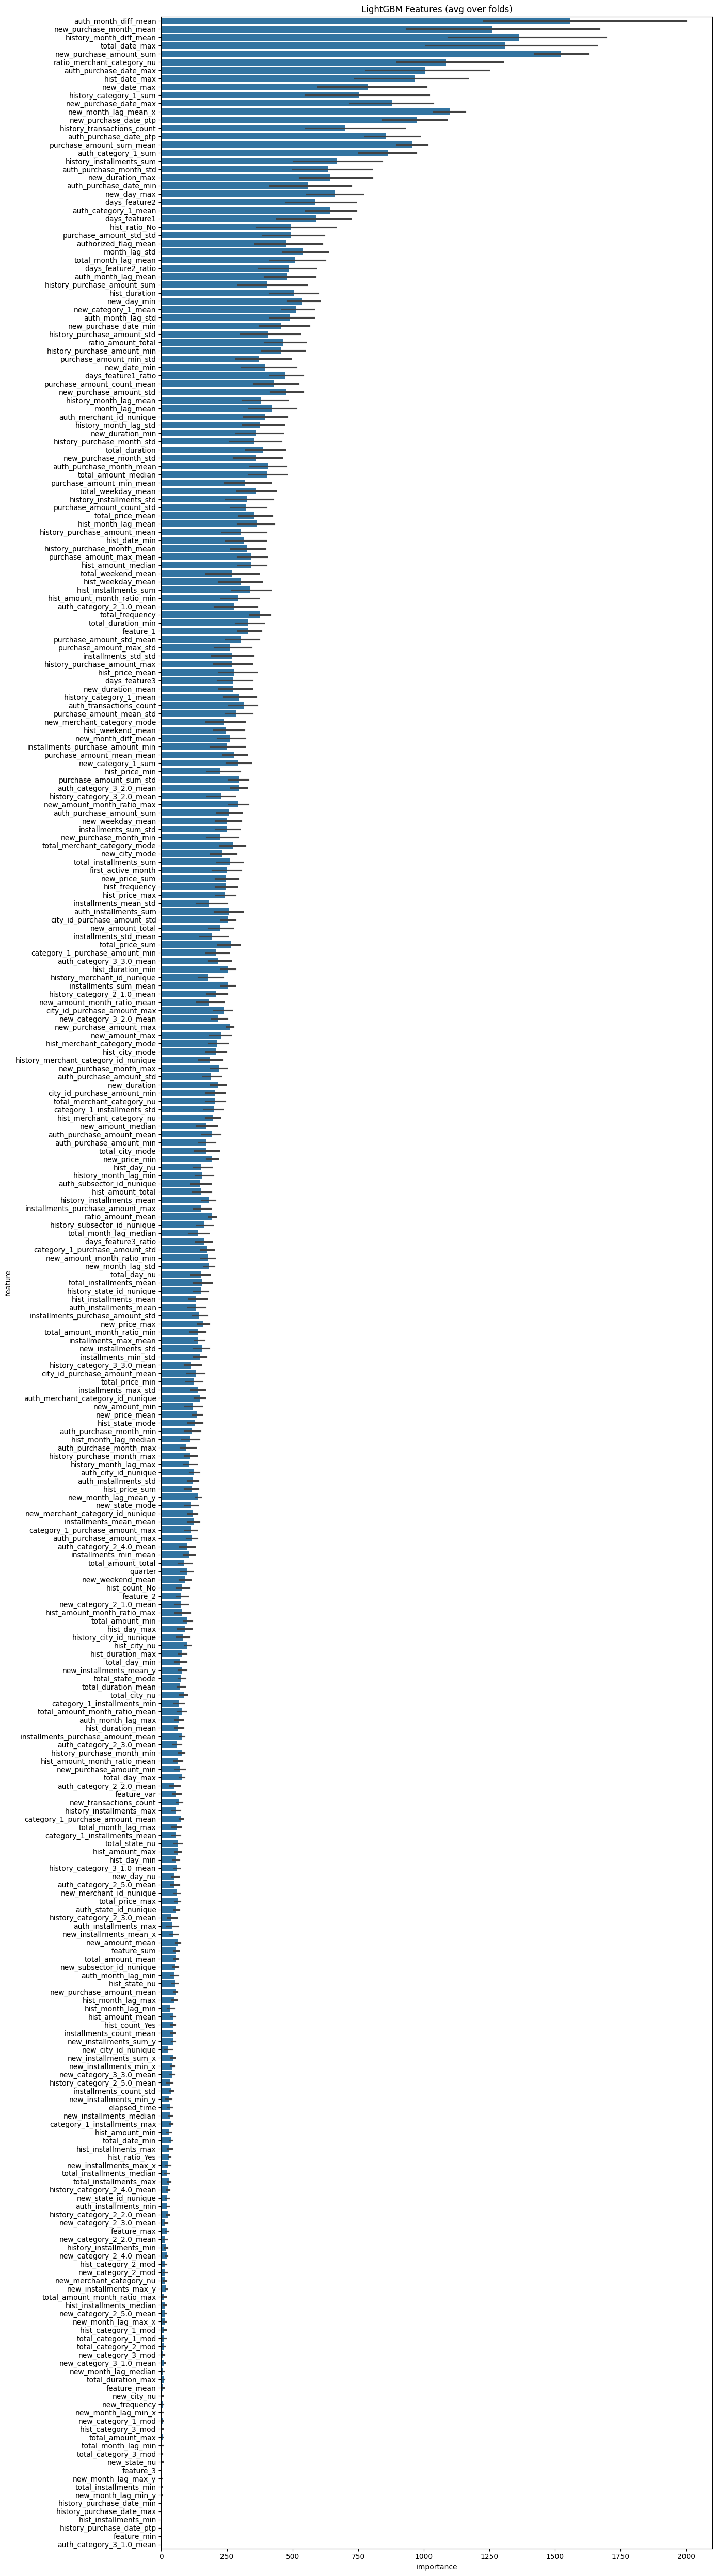

In [16]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')